In [117]:
#importing necessary datasets and python packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

data_df = pd.read_csv("heart.csv")

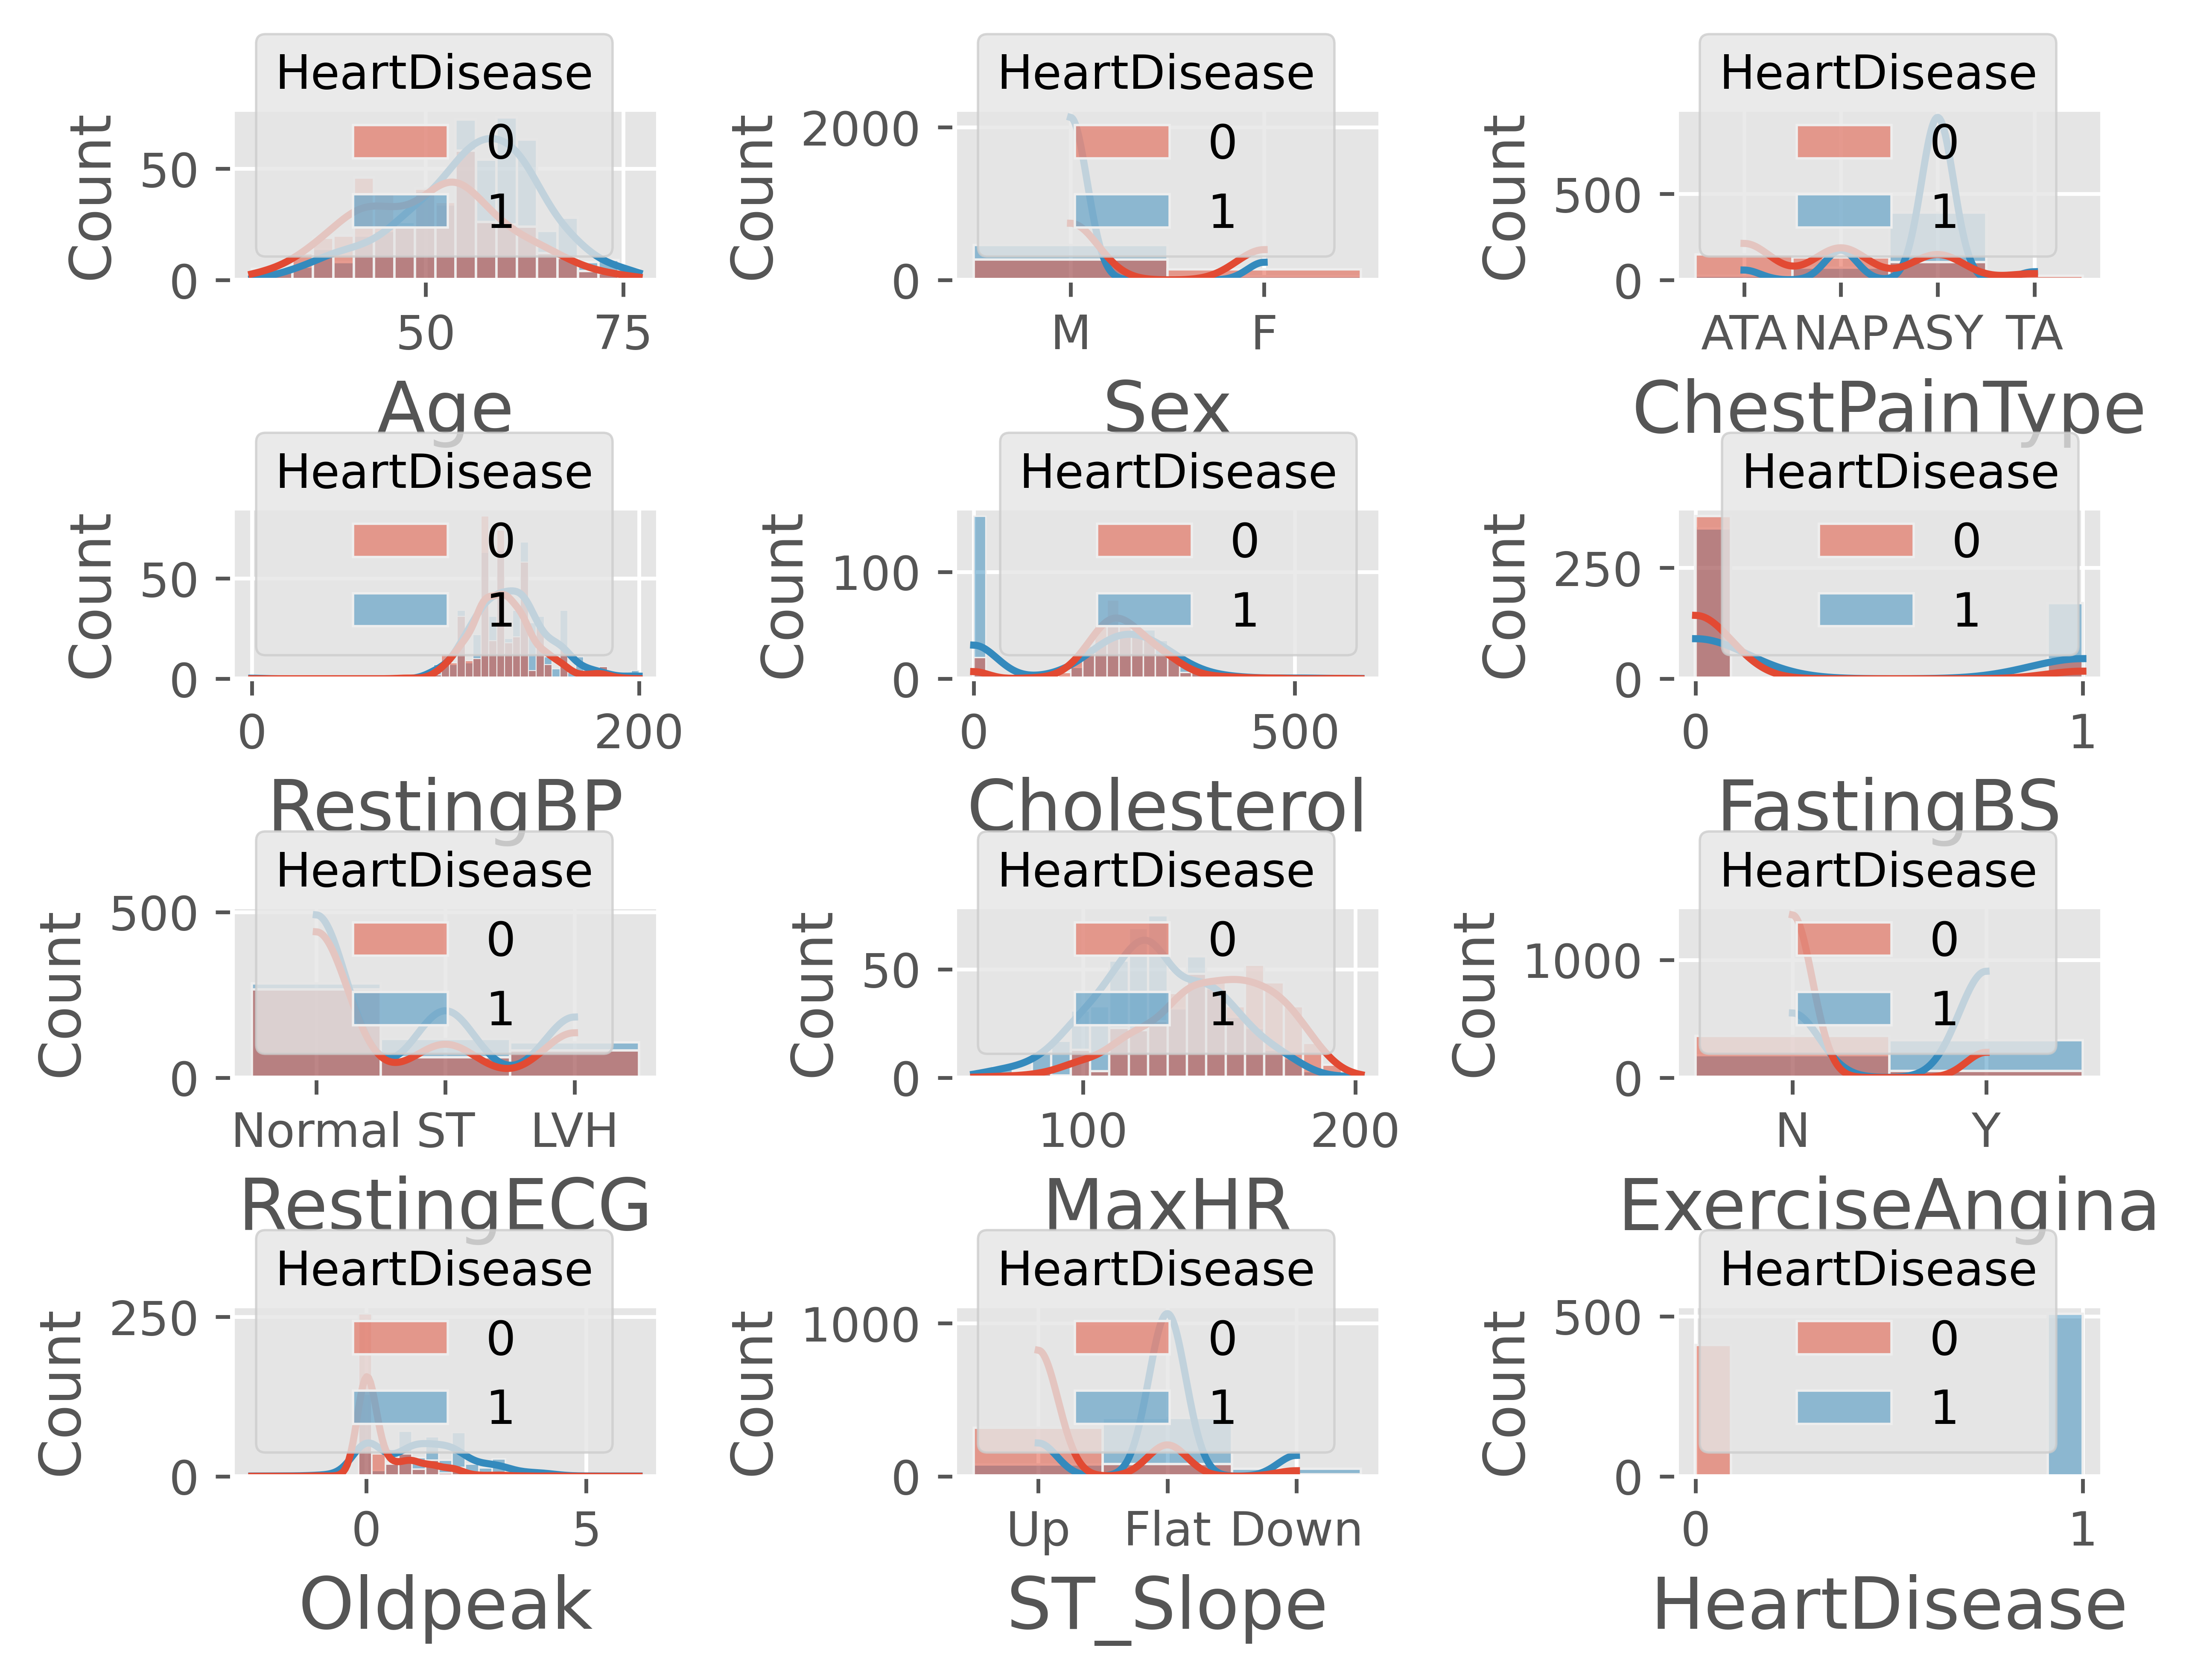

In [2]:
fig, axes = plt.subplots(nrows=4, ncols=3, dpi=800)
axes = axes.flatten()

for i, column in enumerate(data_df.columns):
    sns.histplot(data=data_df, x = column, kde=True, ax=axes[i], hue ="HeartDisease")
    axes[i].set_xlabel(column, fontsize = 15)
    axes[i].grid(True)

fig.width = 50
fig.height = 50
plt.tight_layout()
plt.show()

In [3]:
dummy_gender = pd.get_dummies(data_df['Sex'], prefix='sex', drop_first=True)
dummy_ChestPainType = pd.get_dummies(data_df['ChestPainType'], prefix='ChestPainType', drop_first=True)
dummy_RestingECG = pd.get_dummies(data_df['RestingECG'], prefix='RestingECG', drop_first=True)
dummy_ExerciseAngina = pd.get_dummies(data_df['ExerciseAngina'], prefix='ExerciseAngina', drop_first=True)
dummy_St_Slope = pd.get_dummies(data_df['ST_Slope'], prefix='ST_Slope', drop_first=True)


data_quantitative = pd.concat([data_df.drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1), dummy_gender, dummy_ChestPainType, dummy_RestingECG, dummy_ExerciseAngina, dummy_St_Slope], axis=1)

In [118]:
chol_zero = data_df[data_df["Cholesterol"] == 0]
data_df_keep_chol = data_df.copy()
data_df.loc[data_df["Cholesterol"] == 0, "Cholesterol"] = pd.NA
data_quantitative.loc[data_quantitative["Cholesterol"] == 0, "Cholesterol"] = pd.NA

Making a train / test dataset

In [122]:
from sklearn.model_selection import train_test_split

# Assuming X contains features and y contains labels/target variable
# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data_df.drop("HeartDisease", axis=1), data_df["HeartDisease"], test_size=0.2, random_state=42)

# Split data into training and test sets (80% train, 20% test) for hot-one encoded data
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(data_quantitative.drop("HeartDisease", axis=1), data_df["HeartDisease"], test_size=0.2, random_state=42)

# Split data into training and test sets (80% train, 20% test) for hot-one encoded data
X_train_chol, X_test_chol, y_train_chol, y_test_chol = train_test_split(data_df_keep_chol.drop("HeartDisease", axis=1), data_df["HeartDisease"], test_size=0.2, random_state=42)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Create an instance of DecisionTreeClassifier
DT_model = DecisionTreeClassifier(random_state=42)

cv_accuracy = cross_val_score(DT_model, X_train_dummy, y_train_dummy, cv=8)

print(np.mean(cv_accuracy))

0.7656175346392737


In [41]:
from sklearn.model_selection import cross_val_score
import optuna 

def objective(trial, X_train, y_train):
    params = {
          "max_depth": trial.suggest_int('max_depth', 5, 15),
          "criterion": trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
          "ccp_alpha": trial.suggest_float("ccp_alpha", 0.001, 0.1),
          "min_samples_split": trial.suggest_int("min_samples_split", 2, 10)
    }

    model = DecisionTreeClassifier(random_state=42, **params)
    cv_accuracy = cross_val_score(model, X_train_dummy, y_train_dummy, cv=8)
    
    return np.mean(cv_accuracy)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=60)

[I 2024-03-23 10:09:45,275] A new study created in memory with name: no-name-1a08c553-9f41-4db6-bb32-bbc8705dfc40
[I 2024-03-23 10:09:45,414] Trial 0 finished with value: 0.8147097467749642 and parameters: {'max_depth': 5, 'criterion': 'log_loss', 'ccp_alpha': 0.050511918882967397, 'min_samples_split': 2}. Best is trial 0 with value: 0.8147097467749642.
[I 2024-03-23 10:09:45,542] Trial 1 finished with value: 0.817427138079312 and parameters: {'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.065810570064536, 'min_samples_split': 3}. Best is trial 1 with value: 0.817427138079312.
[I 2024-03-23 10:09:45,662] Trial 2 finished with value: 0.8133361204013378 and parameters: {'max_depth': 9, 'criterion': 'log_loss', 'ccp_alpha': 0.027281903927035004, 'min_samples_split': 3}. Best is trial 1 with value: 0.817427138079312.
[I 2024-03-23 10:09:45,774] Trial 3 finished with value: 0.817427138079312 and parameters: {'max_depth': 7, 'criterion': 'log_loss', 'ccp_alpha': 0.056302024464747566,

In [53]:
params = {'max_depth': 12, 'criterion': 'log_loss', 'ccp_alpha': 0.03617793086335663, 'min_samples_split': 5}

DT_model_tuned = DecisionTreeClassifier(random_state=42, **params)
DT_model_default = DecisionTreeClassifier(random_state=42)

DT_model_tuned.fit(X_train_dummy, y_train_dummy)
DT_model_default.fit(X_train_dummy, y_train_dummy)

y_pred_tuned = DT_model_tuned.predict(X_test_dummy)
y_pred_default = DT_model_default.predict(X_test_dummy)

#### Code for testing accuracy on testset (note; should onlly be done once to avoid overfitting to the testset)

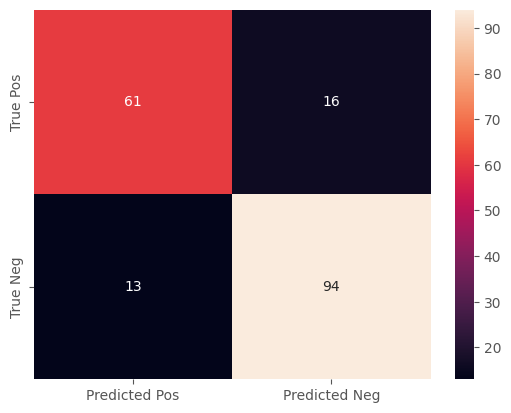

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate confusion matrix
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_pred_tuned), 
                                   index=["True Pos", "True Neg"], 
                                   columns=["Predicted Pos", "Predicted Neg"])

# Plot confusion matrix
fig = plt.figure()
sns.heatmap(confusion_matrix_df, annot=True)
plt.show()


In [54]:
# Calculate accuracy and print
accuracy = accuracy_score(y_test, y_pred_tuned)
accuracy_default = accuracy_score(y_test, y_pred_default)

print(f"The accuracy of hyperparamater tuned is: {accuracy} and the accuracy of not hyperparamater tuned is: {accuracy_default}")

The accuracy of hyperparamater tuned is: 0.842391304347826 and the accuracy of not hyperparamater tuned is: 0.8369565217391305


It seems like the hyperparamater tuning is not helping that much

### 2) Random Forest
Lets now go through the same with a random forest model.
The math behind why we should bag a tree with bootstrap samples is shown below:
$var(\bar{Z}) = var{(1 / n)*\sum{Z_i}} = \frac{1}{n^2}*\sum{var{Z_i}} = \frac{\sigma^2}{n}$

with correlation the last part becomes:
$\text{Var}\left(\sum_{i} X_i\right) = \sum_{i}\sum_{j} \text{Cov}(X_i, X_j)$ 
$\text{Var}\left(\sum_{i} X_i\right) = \sum_{i}\sum_{j} \rho_{ij} \cdot \sigma_i \cdot \sigma_j$
Random Forest therefore only split 

For our hyperparamater tuning we have some special things to take into consideration for a Random Forest:
1) Likly there is no point in pruning the bagged trees as we likly introduce to much bias then
2) Adding more estimators will never hurt our accuracy as we are only reducing the varience more as shown by:
$var(\bar{Z}) = var{(1 / n)*\sum{Z_i}} = \frac{1}{n^2}*\sum{var{Z_i}} = \frac{\sigma^2}{n}$
However for a large n the reduction will become very small and only be unneccesary train time.

Based purly on intuition, it will be very important to reduce varience in the model as we have few datapoints which will cause our model to have a large varience. 

In [55]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial, x_train, y_train):
    params = {
          "max_depth": trial.suggest_int('max_depth', 5, 15),
          "criterion": trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
          "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
          "max_features":  trial.suggest_categorical("max_features", ['sqrt', 'log2']),
          "max_samples": trial.suggest_float("max_samples", 0.5, 1)
    }

    model = RandomForestClassifier(random_state=42, **params)
    cv_accuracy = cross_val_score(model, X_train_dummy, y_train_dummy, cv=5)
    
    return np.mean(cv_accuracy)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=200)


[I 2024-03-23 10:56:53,674] A new study created in memory with name: no-name-4ad903fe-3b4e-4966-964d-a549013665a5
[I 2024-03-23 10:56:55,181] Trial 0 finished with value: 0.8705619233994968 and parameters: {'max_depth': 15, 'criterion': 'log_loss', 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.9353349102104844}. Best is trial 0 with value: 0.8705619233994968.
[I 2024-03-23 10:56:56,474] Trial 1 finished with value: 0.871922467617184 and parameters: {'max_depth': 15, 'criterion': 'entropy', 'min_samples_split': 10, 'max_features': 'log2', 'max_samples': 0.7143686323477707}. Best is trial 1 with value: 0.871922467617184.
[I 2024-03-23 10:56:57,882] Trial 2 finished with value: 0.862361382909328 and parameters: {'max_depth': 14, 'criterion': 'log_loss', 'min_samples_split': 3, 'max_features': 'log2', 'max_samples': 0.5409687733172253}. Best is trial 1 with value: 0.871922467617184.
[I 2024-03-23 10:56:59,326] Trial 3 finished with value: 0.8705526046034852 and parameter

In [98]:
params_RF = {'max_depth': 10, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 'sqrt', 'max_samples': 0.8809355563957624}

RF_model_tuned = RandomForestClassifier(random_state=42, **params_RF, n_estimators = 500)
RF_model_default = RandomForestClassifier(random_state=42)

RF_model_tuned.fit(X_train_dummy, y_train_dummy)
RF_model_default.fit(X_train_dummy, y_train_dummy)

RFy_pred_tuned = RF_model_tuned.predict(X_test_dummy)
RFy_pred_default = RF_model_default.predict(X_test_dummy)

In [99]:
# Calculate accuracy and print
accuracy = accuracy_score(y_test, RFy_pred_tuned)
accuracy_default = accuracy_score(y_test, RFy_pred_default)

print(f"The accuracy of hyperparamater tuned is: {accuracy} and the accuracy of not hyperparamater tuned is: {accuracy_default}")

The accuracy of hyperparamater tuned is: 0.875 and the accuracy of not hyperparamater tuned is: 0.8695652173913043


#### Creating a analyze the effect of n_estimators for random forest
Just a quick plot to confirm the math of more estimators

In [76]:
test_accuracy_list = []
for i in range(1,300):
    RF_model = RF_model_tuned = RandomForestClassifier(random_state=42, **params_RF, n_estimators = i)
    RF_model.fit(X_train_dummy, y_train_dummy)
    RF_pred_y = RF_model.predict(X_test_dummy)
    accuracy_RF = accuracy_score(y_test, RF_pred_y)
    test_accuracy_list.append(accuracy_RF)


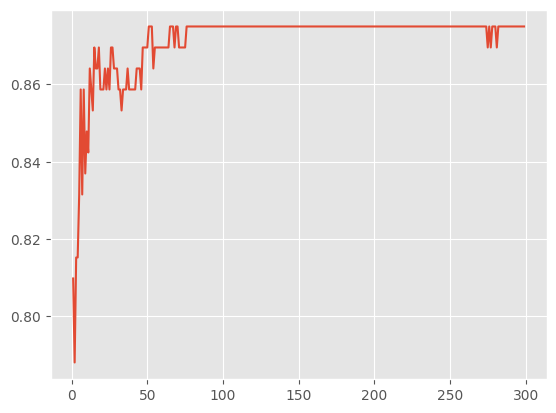

In [78]:
fig = plt.figure()
plt.plot(range(1, 300), test_accuracy_list)

### Boosted Decision Tree
We now trying to implement a boosted decision tree. This can be done from scratch using small decision trees (to ensure that we are creating an ensamble of weak learner, as the goal of boosting is primarily to decrease the bias of a weak learner and not to reduce the variance of a strong learner) and using a gradient boosting algorithm. Or we can import a finished implementation. 

Here we choose to use the simple gradient boosted decision tree classifier from Scikit learn. 

In [82]:
from sklearn.ensemble import HistGradientBoostingClassifier

def objective(trial, x_train, y_train):
    params = {
          "max_depth": trial.suggest_int('max_depth', 4, 6), #typical values
          "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
          "max_iter": trial.suggest_int("max_iter", 100, 1000),
          "max_features": trial.suggest_categorical("max_features", [0.5, 0.8, 1.0]) #attempts to reduce varience more by randomizing features per split like random forest
    }

    model = HistGradientBoostingClassifier(random_state=42, **params)
    cv_accuracy = cross_val_score(model, X_train_dummy, y_train_dummy, cv=5)
    
    return np.mean(cv_accuracy)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=150)


[I 2024-03-23 12:28:36,276] A new study created in memory with name: no-name-d04f1861-d432-42b9-964b-d8e6d0c1802a
[I 2024-03-23 12:28:39,346] Trial 0 finished with value: 0.851532941943901 and parameters: {'max_depth': 6, 'learning_rate': 0.028375946320027927, 'max_iter': 577, 'max_features': 0.8}. Best is trial 0 with value: 0.851532941943901.
[I 2024-03-23 12:28:42,235] Trial 1 finished with value: 0.8515236231478893 and parameters: {'max_depth': 4, 'learning_rate': 0.05128051945543802, 'max_iter': 866, 'max_features': 0.8}. Best is trial 0 with value: 0.851532941943901.
[I 2024-03-23 12:28:45,850] Trial 2 finished with value: 0.8392694063926941 and parameters: {'max_depth': 5, 'learning_rate': 0.08199011025121306, 'max_iter': 830, 'max_features': 0.8}. Best is trial 0 with value: 0.851532941943901.
[I 2024-03-23 12:28:48,557] Trial 3 finished with value: 0.8515143043518778 and parameters: {'max_depth': 6, 'learning_rate': 0.05469527070564965, 'max_iter': 558, 'max_features': 1.0}. B

In [84]:
print("Best trial value:", study.best_params, study.best_value)

Best trial value: {'max_depth': 6, 'learning_rate': 0.011666347379020644, 'max_iter': 390, 'max_features': 0.5} 0.8814649147330165


In [91]:
params_GBM = {'max_depth': 6, 'learning_rate': 0.011666347379020644, 'max_iter': 390, 'max_features': 0.5}
GBM_model_tuned = HistGradientBoostingClassifier(random_state=42, **params_GBM)
GBM_model_default = HistGradientBoostingClassifier(random_state=42)

GBM_model_tuned.fit(X_train_dummy, y_train_dummy)
GBM_model_default.fit(X_train_dummy, y_train_dummy)

GBMy_pred_tuned = GBM_model_tuned.predict(X_test_dummy)
GBMy_pred_default = GBM_model_default.predict(X_test_dummy)

In [92]:
# Calculate accuracy and print
accuracy = accuracy_score(y_test, GBMy_pred_tuned)
accuracy_default = accuracy_score(y_test, GBMy_pred_default)

print(f"The accuracy of hyperparamater tuned is: {accuracy} and the accuracy of not hyperparamater tuned is: {accuracy_default}")

The accuracy of hyperparamater tuned is: 0.8804347826086957 and the accuracy of not hyperparamater tuned is: 0.8804347826086957


This is a realativly good performance, without doing a large amount of hyperparamater tuning. It's worth noting that we can likly increase this by tuning down variance some by performing stochastic GBM, but the scikit-learn package does not currently support this. 

#### Lets do a quick CatBoost and see how it performs
as the hyperparamaters are so diverse, we just use the default ones. 

In [94]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier

#Create a pool of data
train_pool = Pool(X_train, y_train, cat_features=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
test_pool = Pool(X_test, cat_features=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']) 

cat_feature = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

#init model and fit it
catboost_model = CatBoostClassifier(cat_features=cat_feature, verbose=100)
catboost_model.fit(train_pool)

Learning rate set to 0.009028
0:	learn: 0.6855152	total: 189ms	remaining: 3m 8s
100:	learn: 0.3652839	total: 3.37s	remaining: 30s
200:	learn: 0.2853155	total: 7.81s	remaining: 31.1s
300:	learn: 0.2528162	total: 12s	remaining: 28s
400:	learn: 0.2324268	total: 15.8s	remaining: 23.5s
500:	learn: 0.2168137	total: 18.6s	remaining: 18.6s
600:	learn: 0.2041170	total: 22.8s	remaining: 15.2s
700:	learn: 0.1905366	total: 26.7s	remaining: 11.4s
800:	learn: 0.1778972	total: 30.2s	remaining: 7.5s
900:	learn: 0.1652640	total: 33.7s	remaining: 3.7s
999:	learn: 0.1541681	total: 37.3s	remaining: 0us


In [95]:
CBy_pred = catboost_model.predict(test_pool)
accuracy = accuracy_score(y_test, CBy_pred)

print(f"The accuracy of catboost model is: {accuracy}")

The accuracy of catboost model is: 0.8858695652173914


### Finally lets attempt a quick stack
This will hopefully reduce the varience of the combined model and give a higher accuracy.
Based on results below, we likly have to similare models for the stack to actually be of any use

In [132]:
from collections import Counter

def majority_vote(arrays):
    # Transpose the list of lists to group votes for each index
    transposed_arrays = zip(*arrays)
    
    # Perform majority vote for each index
    majority_votes = [Counter(votes).most_common(1)[0][0] for votes in transposed_arrays]
    
    return majority_votes

# Example usage
arrays = [CBy_pred, GBMy_pred_tuned, y_pred_tuned]
result = majority_vote(arrays)

accuracy = accuracy_score(y_test, result)

print(f"The accuracy of catboost model is: {accuracy}")

The accuracy of catboost model is: 0.8858695652173914
